# Multiple Choice Q-A con prompts contextualizados

El propósito de este notebook es experimentar con un modelo Decoder-only y prompts contextualizados haciendo una búsqueda de documentos relacionados en una base de datos externa previamente indexada. El proceso de obtención de resultados es idéntico al del notebook **decoders_mca.ipynb**, donde:

1. Carga de un modelo y tokenizer preentrenado.
2. Preparación del prompt de entrada para el modelo con el fin de obtener una respuesta (entre A y E) correspondiente a la opción correcta, en este caso, añadiendo contexto.
3. Obtención de logits referentes a la última capa y aplicación de softmax para obtener probabilidades de las letras A, B, C, D y E.
4. Evaluación del desempeño del modelo en un conjunto de datos de prueba.

In [1]:
!pip install chromadb sentence-transformers --quiet

In [ ]:
# base de datos vectorial
import chromadb

# embeddings
from sentence_transformers import SentenceTransformer

from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import pandas as pd

import numpy as np
from tqdm import tqdm

# Métricas de clasificación
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
)

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Limpieza de memoria
import gc


device = "cuda" if torch.cuda.is_available() else "cpu"

/home/estudiante/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Cargar la base de datos vectorial con Chroma DB

In [3]:
# usamos los mismos embeddings que en la indexación
embedder = SentenceTransformer("hiiamsid/sentence_similarity_spanish_es")

# conectamos a la colección 
client = chromadb.PersistentClient(path="./Results/medical_db")
collection = client.get_collection("medical_documents")
print(f"Número de documentos en la colección: {collection.count()}")

Número de documentos en la colección: 100000


## Definir funciones para obtener contexto y responder preguntas

La función para obtener contexto de la base de datos tiene como parametro configurable el número de documentos a recuperar y un threshold de similitud con el fin de filtrar documentos poco relevantes.

In [4]:
def retrieve_context(question:str, k:int=5, similarity_threshold:float=0.35):
    """
    Recupera documentos relevantes de la base de datos vectorial para una pregunta dada.
    Args:
    - question (str): La pregunta para la cual se busca contexto.
    - k (int): Número de documentos a recuperar.
    - similarity_threshold (float): Umbral de similitud para filtrar documentos.
    
    Returns:
    - List[Dict]: Lista de documentos relevantes con sus scores de similitud.
    """
    # crear el embedding de la pregunta
    query_embedding = embedder.encode([question]).tolist()

    # consultar la colección
    results = collection.query(
        query_embeddings=query_embedding,
        n_results=k,
        include=["distances", "documents"]
    )

    # obtener documentos y distancias (coseno)
    docs = results["documents"][0]
    distances = results["distances"][0] 

    filtered_docs = []
    for doc, dist in zip(docs, distances):
        similarity = 1 - dist  # calcular el score de similitud

        if similarity >= similarity_threshold:
            filtered_docs.append({
                "document": doc,
                "similarity": similarity
            })

    return filtered_docs


## Lectura de datos y prueba conceptual

In [5]:
test_df = pd.read_csv("data/test.csv", index_col=0)
test_df.head()

,qid,qtext,ra,image,answer_1,answer_2,answer_3,answer_4,answer_5
4039,87,El virión de los retrovirus:,4,NaN,Tiene forma helicoidal.,Tiene forma icosaédrica.,Contiene una sola copia de su genoma.,Contiene dos copias de su genoma.,Contiene un genoma segmentado.
4173,224,El suelo de la cavidad amniótica es el:,3,NaN,Trofoblasto.,Hipoblasto.,Epiblasto.,Endometrio.,Miometrio.
3975,18,Las señales sensitivas llegan principalmente a...,3,NaN,II.,III.,IV.,V.,VI.
2470,25,Las desviaciones instrumentales de la Ley de B...,2,NaN,Variaciones en la temperatura lo que provoca d...,Empleo de radiación no monocromática y presenc...,"Empleo de concentraciones elevadas de analito,...",La participación de la especie absorbente en u...,Respuesta incorrecta
2255,36,La presencia de síntomas o déficits que afecta...,3,NaN,Trastorno somatomorfo indiferenciado.,Trastorno de somatización.,Trastorno de conversión.,Trastorno por dolor.,Respuesta incorrecta


In [6]:
# probar la función de recuperación de contexto con una pregunta de ejemplo
q_example = test_df.iloc[45]["qtext"]
print(f"Pregunta de ejemplo: {q_example}")
retrieved_docs = retrieve_context(q_example, k=1, similarity_threshold=0.5)
print("Documentos recuperados:")
for idx, doc in enumerate(retrieved_docs):
    print(f"Documento {idx+1} (Similitud: {doc['similarity']:.4f}): {doc['document']}")

Pregunta de ejemplo: En un paciente con enfermedad pulmonar obstructiva crónica (EPOC) leve en fase estable se evidencia poliglobulia e insuficiencia respiratoria. En la radiografía de tórax no se aprecian alteraciones reseñables. ¿Cuál de los siguientes procedimientos consideraría realizar en primer lugar para descartar la coexistencia de otras enfermedades que puedan justificar los hallazgos descritos?:
Documentos recuperados:
Documento 1 (Similitud: 0.8123): Carrillo-Esper R, de la Torre-León T, Carrillo-Córdova CA, Carrillo-Córdova DM
Actualidades en la definición, fisiopatología y tratamiento de la lesión pulmonar aguda
El síndrome de dificultad respiratoria aguda se origina por una lesión pulmonar inflamatoria, concomitante con diversos eventos celulares y moleculares que provocan la lesión de la membrana alveolo-capilar, lo que resulta en incremento de la permeabilidad y el subsecuente edema intersticial y alveolar.
El diagnóstico de síndrome de dificultad respiratoria aguda se 

## Decoder con contexto recuperado
Este proceso consiste en recuperar el contexto más relevante para cada pregunta y utilizarlo dentro del prompt enviado al modelo decoder. Las posibles respuestas se formatean como opciones de selección múltiple (A–E), de modo que el modelo solo debe generar una letra como salida.

Tras construir el prompt, el modelo genera un único token. A partir de los logits correspondientes al último token producido, que representan la puntuación asignada a cada posible letra, se calcula la probabilidad de cada opción aplicando una función softmax. La respuesta final es aquella cuya letra presenta la mayor probabilidad, interpretada como la opción más plausible según el modelo.


In [7]:
# modelo a usar
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.3"

Función para cargar el modelo y tokenizador.

In [16]:
def load_model_and_tokenizer(model_name: str):
    """
    Carga el modelo y el tokenizador desde Hugging Face.
    Args:
    - model_name (str): Nombre del modelo en Hugging Face.
    
    Returns:
    - model: Modelo cargado.
    - tokenizer: Tokenizador cargado.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        # dtype = torch.float16
        device_map = "auto",
        load_in_8bit = True
    )#.to("cuda")
    model.eval()
    return model, tokenizer

Función que implementa la lógica previamente descrita.

In [28]:
def score_response_logits(model:AutoModelForCausalLM, tokenizer:AutoTokenizer, question:str, context:str, answers:list[str]):

    """Calcula la respuesta más probable dada una pregunta, contexto y opciones de respuesta utilizando los logits del modelo.

    Args:
    - model (AutoModelForCausalLM): Modelo de lenguaje.
    - tokenizer (AutoTokenizer): Tokenizador.
    - question (str): Pregunta.
    - context (str): Contexto.
    - answers (list[str]): Opciones de respuesta.
    Returns:
    - best_answer (str): Respuesta más probable.
    """
    if answers[4] == "Respuesta incorrecta":
        answers = answers[:-1]
    letters = ['A', 'B', 'C', 'D', 'E'][:len(answers)]

    options_text = "\n".join(f"{letters[i]}) {answers[i]}" for i in range(len(answers)))

    prompt = f"""
Eres un **examinador experto** en ambitos biomedicos.
Debes seleccionar la opción correcta entre las siguientes.
Responde únicamente con UNA letra (A, B, C, D o E) según corresponda.
Si no conoces la respuesta, apoyate en el contexto para responderla satisfactoriamente.
Piensa paso a paso.

Pregunta:
{question}

Opciones:
{options_text}

Contexto:
{context}

Respuesta (solo la letra):
""".strip()

    # pasar prompt a tokens (ids)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    input_ids = inputs["input_ids"]

    # generar un token (la letra) y mirar la probabilidad
    scores = []
    with torch.no_grad():
        outputs = model(input_ids, max_new_tokens=1)
        logits = outputs.logits  # [batch = 1, seq_len, vocab_size]
        last_token_logits = logits[0, -1, :].detach().cpu() # tomar los logits del último token (letra generada)
        for letter in letters:
            token_id = tokenizer.convert_tokens_to_ids(letter)
            log_prob = torch.log_softmax(last_token_logits, dim=-1)[token_id].item() # tomar la prob de generar cada letra
            scores.append(log_prob)

    best_index = scores.index(max(scores))
    best_answer = answers[best_index]
    # print("Prob best answer:", max(scores))
    return best_answer

In [ ]:
def score_response_logits(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    question: str,
    context: str,
    answers: list[str]
):
    """
    Versión optimizada que:
    - tokeniza en CPU
    - sólo mueve input_ids a GPU
    - usa no grad + no cache
    - mueve logits inmediatamente a CPU
    - no usa variables eliminadas en finally
    """

    # limpiar respuesta inválida
    if len(answers) >= 5 and answers[4] == "Respuesta incorrecta":
        answers = answers[:4]

    letters = ['A', 'B', 'C', 'D', 'E'][:len(answers)]

    options_text = "\n".join(
        f"{letters[i]}) {answers[i]}" for i in range(len(answers))
    )

    prompt = f"""
Eres un **examinador experto** en ambitos biomedicos.
Debes seleccionar la respuesta correcta entre las siguientes opciones.Responde únicamente con UNA letra (A, B, C, D o E) según corresponda.
Si no estás seguro de la respuesta, apoyate en el contexto para responderla satisfactoriamente.
Piensa paso a paso.

Pregunta:
{question}

Opciones:
{options_text}

Contexto:
{context}

Respuesta (solo la letra):
""".strip()

    # Tokenizar en CPU
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=2048
    )

    input_ids = inputs["input_ids"]
    attention_mask = inputs.get("attention_mask", None)

    device = next(model.parameters()).device

    # realizar inferencia
    with torch.inference_mode():
        input_ids_gpu = input_ids.to(device)

        attn_gpu = None
        if attention_mask is not None:
            attn_gpu = attention_mask.to(device)

        outputs = model(
            input_ids_gpu,
            attention_mask=attn_gpu,
            use_cache=False,
            return_dict=True
        )

        # se obtienen los logits del último token
        last_token_logits = outputs.logits[0, -1, :].detach().cpu()

    # limpiar GPU para evitar problemas de memoria
    del input_ids_gpu, attn_gpu, outputs
    torch.cuda.empty_cache()
    gc.collect()

    # calcular probabilidades con softmax
    log_probs = torch.log_softmax(last_token_logits, dim=-1)

    scores = []
    for letter in letters:
        ids = tokenizer.encode(letter, add_special_tokens=False)
        token_id = ids[0] if len(ids) > 0 else tokenizer.convert_tokens_to_ids(letter)
        scores.append(log_probs[token_id].item())

    best_index = int(torch.tensor(scores).argmax().item())
    return answers[best_index]


A continuación se carga el modelo y tokenizer.

In [18]:
model, tokenizer = load_model_and_tokenizer(MODEL_NAME)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████████████| 3/3 [00:14<00:00,  4.68s/it]


In [19]:
# Prueba conceptual 
example = test_df.iloc[3]
q_example = example["qtext"]
real_answer = example[f"answer_{example['ra']}"]
answers_example = [example[f"answer_{i}"] for i in range(1,6)
]
retrieved_docs = retrieve_context(q_example, k=3, similarity_threshold=0.5)
retrieved_docs_text = [doc['document'] for doc in retrieved_docs]

retrieved_docs_text = " ".join(retrieved_docs_text)
response = score_response_logits(model, tokenizer, q_example, retrieved_docs_text, answers_example)


In [20]:
print('Pregunta:', q_example)
print("Posibles respuestas", answers_example)
print("Contexto:", retrieved_docs)
print("Respuesta correcta: ", real_answer)
print("Respuesta modelo: ", response)

Pregunta: Las desviaciones instrumentales de la Ley de Beer se deben principalmente a:
Posibles respuestas ['Variaciones en la temperatura lo que provoca desplazamientos del equilibrio químico.', 'Empleo de radiación no monocromática y presencia de radiación parásita.', 'Empleo de concentraciones elevadas de analito, lo que modifica el índice de refracción de la disolución.', 'La participación de la especie absorbente en un equilibrio químico o físico, lo que puede modificar su concentración en el momento de la medida.', 'Respuesta incorrecta']
Contexto: []
Respuesta correcta:  Empleo de radiación no monocromática y presencia de radiación parásita.
Respuesta modelo:  Empleo de radiación no monocromática y presencia de radiación parásita.


## Segunda opción de retrieval

Podemos notar que muchas de las preguntas quedan incompletas sin las respuestas (como en el ejemplo previo a este apartado), por lo que el retrieval del contexto puede quedar corto. A continuación se crea una segunda opción de query que toma en cuenta tanto pregunta como posibles respuestas.

In [21]:
def build_retrieval_query(question:str, answers:list[str]):
    """
    Se crea un string de query teniendo en cuenta la pregunta y posibles respuestas.
    """
    answers_text = " ".join(answers)
    return f"{question}. Opciones: {answers_text}"

In [22]:
# Prueba conceptual 
example = test_df.iloc[3]
q_example = example["qtext"]
real_answer = example[f"answer_{example['ra']}"]
answers_example = [example[f"answer_{i}"] for i in range(1,6)
]
query = build_retrieval_query(q_example, answers_example)
retrieved_docs = retrieve_context(query, k=1, similarity_threshold=0.5)
retrieved_docs_text = [doc['document'] for doc in retrieved_docs]

retrieved_docs_text = " ".join(retrieved_docs_text)
response = score_response_logits(model, tokenizer, q_example, retrieved_docs_text, answers_example)


In [23]:
print('Pregunta:', q_example)
print("Posibles respuestas", answers_example)
print("Contexto:", retrieved_docs)
print("Respuesta correcta: ", real_answer)
print("Respuesta modelo: ", response)

Pregunta: Las desviaciones instrumentales de la Ley de Beer se deben principalmente a:
Posibles respuestas ['Variaciones en la temperatura lo que provoca desplazamientos del equilibrio químico.', 'Empleo de radiación no monocromática y presencia de radiación parásita.', 'Empleo de concentraciones elevadas de analito, lo que modifica el índice de refracción de la disolución.', 'La participación de la especie absorbente en un equilibrio químico o físico, lo que puede modificar su concentración en el momento de la medida.', 'Respuesta incorrecta']
Contexto: [{'document': 'El Principio de Le Chatelier, de 1888, se refiere a que un estado de equilibrio químico es mantenido en tanto no se alteren las condiciones del sistema.\nCuando se modifica algún parámetro, como por ejemplo, la presión, la temperatura o la concentración de algunas de las especies en equilibrio, este se traslada en cierta dirección (hacia los reactivos o hacia los productos) hasta alcanzar un nuevo estado de equilibrio.\n

## Evaluación

Se crea una función de evaluación.

In [ ]:
def evaluate_model_logits(test_data: pd.DataFrame, model: AutoModelForCausalLM, tokenizer: AutoTokenizer):
    """
    Evalúa el modelo en un conjunto de datos de prueba.
    Args:
    - test_data (pd.DataFrame): Conjunto de datos de prueba.
    - model (AutoModelForCausalLM): Modelo de lenguaje.
    - tokenizer (AutoTokenizer): Tokenizador.
    Returns:
    - metrics (dict): Diccionario con métricas de evaluación.
    """
    all_preds = []
    all_labels = []

    total = len(test_data)

    for index, row in tqdm(test_data.iterrows(), total=total, desc="Evaluating"):
        question = row["qtext"]
        answers = [
            row["answer_1"],
            row["answer_2"],
            row["answer_3"],
            row["answer_4"],
            row["answer_5"],
        ]
        # crear la query
        query = build_retrieval_query(question, answers)
        
        # obtener el contexto
        retrieved_docs = retrieve_context(query, k=1, similarity_threshold=0.8) # antes eran 3 a 0.6. Esto fue lo que mejor funcionó
        retrieved_docs_text = [doc['document'] for doc in retrieved_docs]
        context = " ".join(retrieved_docs_text)
        
        real_answer = row["ra"]  # 1–5

        # obtener texto predicho
        with torch.inference_mode():
            predicted_answer = score_response_logits(model, tokenizer, question, context, answers)
    
            # convertir predicción a índice
            pred_index = answers.index(predicted_answer)  # 0–4
    
            all_preds.append(pred_index)
            all_labels.append(real_answer - 1)  # convertir 1–5 a 0–4

            gc.collect()
            torch.cuda.empty_cache()
        

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # metricas
    valid_mask = all_preds != -1
    invalid_predictions = np.sum(all_preds == -1)

    print(f"Predicciones inválidas (fuera de opciones): {invalid_predictions}")

    if invalid_predictions > 0:
        print("Nota: las predicciones inválidas se excluyen de métricas de F1/precision/recall.")

    metrics = {
        "Accuracy": np.mean(all_preds == all_labels),
        "F1 Macro": f1_score(all_labels[valid_mask], all_preds[valid_mask], average='macro'),
        "F1 Micro": f1_score(all_labels[valid_mask], all_preds[valid_mask], average='micro'),
        "F1 Weighted": f1_score(all_labels[valid_mask], all_preds[valid_mask], average='weighted'),

        "Precision Macro": precision_score(all_labels[valid_mask], all_preds[valid_mask], average='macro'),
        "Precision Micro": precision_score(all_labels[valid_mask], all_preds[valid_mask], average='micro'),
        "Precision Weighted": precision_score(all_labels[valid_mask], all_preds[valid_mask], average='weighted'),

        "Recall Macro": recall_score(all_labels[valid_mask], all_preds[valid_mask], average='macro'),
        "Recall Micro": recall_score(all_labels[valid_mask], all_preds[valid_mask], average='micro'),
        "Recall Weighted": recall_score(all_labels[valid_mask], all_preds[valid_mask], average='weighted'),
    }

    print("Resultados de la evaluación:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    print("Classification Report:")
    print(classification_report(all_labels[valid_mask], all_preds[valid_mask]))

    cm = confusion_matrix(all_labels[valid_mask], all_preds[valid_mask])
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    labels = [1, 2, 3, 4, 5]

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm_normalized, annot=True, fmt=".2f", cmap="Blues",
        xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Normalized Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return metrics


Evaluating: 100%|█████████████████████████████| 790/790 [07:37<00:00,  1.73it/s]


Predicciones inválidas (fuera de opciones): 0
Resultados de la evaluación:
Accuracy: 0.5405
F1 Macro: 0.5270
F1 Micro: 0.5405
F1 Weighted: 0.5373
Precision Macro: 0.5473
Precision Micro: 0.5405
Precision Weighted: 0.5487
Recall Macro: 0.5214
Recall Micro: 0.5405
Recall Weighted: 0.5405
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.68      0.57       191
           1       0.57      0.43      0.49       190
           2       0.55      0.56      0.55       171
           3       0.60      0.54      0.56       181
           4       0.53      0.40      0.46        57

    accuracy                           0.54       790
   macro avg       0.55      0.52      0.53       790
weighted avg       0.55      0.54      0.54       790



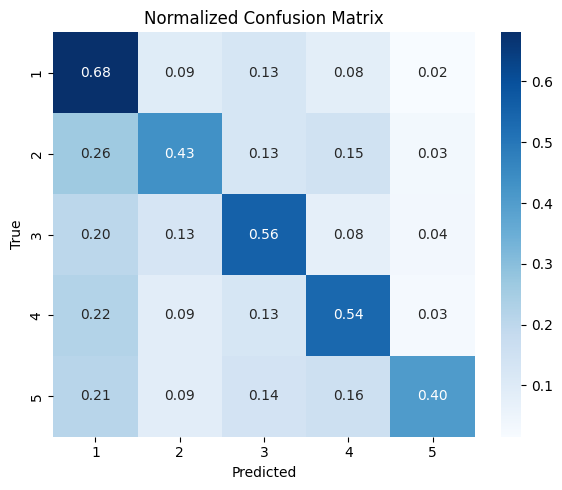

In [29]:
metrics = evaluate_model_logits(test_df, model, tokenizer)

Los mejores resultados se obtuvieron recuperando el mejor documento (k=1) con un umbral de similitud de 0.8, y utilizando tanto la pregunta como las posibles respuestas para construir la query de recuperación. Comparado con los resultados del mismo modelo sin contexto, se observa una ligera mejora en las métricas generales. 